<a href="https://colab.research.google.com/github/prateekkalakuntla/Martin-Lab-Machine-Learning/blob/master/embryo_baseline_prateek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [ ]:
# HANNAH ADDED
!pip install keras-layer-normalization

In [ ]:
class Config:
  DATASET_PATH ="/content/drive/My Drive/EmbryoMachineLearning/Autoencoder_UCSD/UCSD_Anomaly_Dataset.v1p2/Embryo_Anomaly/Pulsing_Train"
  SINGLE_TEST_PATH = "/content/drive/My Drive/EmbryoMachineLearning/Autoencoder_UCSD/UCSD_Anomaly_Dataset.v1p2/Embryo_Anomaly/Pulsing_Test/Movie_32" # "/content/drive/My Drive/EmbryoMachineLearning/Autoencoder_UCSD/UCSD_Anomaly_Dataset.v1p2/Embryo_Anomaly/Pulsing_Test/Movie_32","/content/drive/My Drive/EmbryoMachineLearning/Autoencoder_UCSD/UCSD_Anomaly_Dataset.v1p2/Embryo_Anomaly/Pulsing_Test/Spn_02"]
  BATCH_SIZE = 2
  EPOCHS = 10
  MODEL_PATH = "/content/drive/My Drive/EmbryoMachineLearning/Autoencoder_UCSD/UCSD_Anomaly_Dataset.v1p2/embryo_model_prateek.hdf5"

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import random

#Code Block 1
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
      A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    #changed input shape to 3
    clip = np.zeros(shape=(sequence_size, 256, 256, 3))
    cnt = 0
    cnt2 = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, :] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                clip = np.zeros(shape=(sequence_size, 256, 256, 3))
                cnt = 0
    return clips

#Code Block 2
def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    new_clips = []
    i = 0 
    # loop over the training folders (Train000,Train001,..)
    new_list = listdir(Config.DATASET_PATH)
    random.shuffle(new_list)
    for f in new_list:
        #Prateek control images, 31 images
        print(f)
        i += 1
        if i == 11:
          break
        print("looping...")
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "jpg":
                    img = Image.open(img_path).resize((256, 256))
                    #black and white
                    #img = np.dot(img,[.299,.587,.144])
                    img = np.array(img)/256
                    all_frames.append(img)
            #get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                new_clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    print("done looping.")
    return new_clips

In [ ]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization




def get_model(training_set, reload_model):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    print("4")
    training_set = np.array(training_set)
    print("5")
    seq = Sequential()
    print("6")

    #Prateek changed batch input shape to last item = 3
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 3)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(3, (11, 11), activation="sigmoid", padding="same")))

    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [ ]:
def get_single_test():
    #Prateek changed sz 
    sz = len(listdir(Config.SINGLE_TEST_PATH))
    test = np.zeros(shape=(sz, 256, 256, 3))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "jpg":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            #Black and white
            #img = np.dot(img, [.299,.587,.144])
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, :] = img
            cnt = cnt + 1
    return test

In [ ]:
import matplotlib.pyplot as plt

def evaluate(training_set, out_model):
    print("starting")
    model = get_model(training_set, out_model)
    # Hannah changed
    #model = get_model(False)
    print("got model")
    test = get_single_test()
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 3))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 3))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=2)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ticklabel_format(useOffset=False)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [ ]:
training_set = get_training_set()

Movie_27
looping...
Movie_15
looping...
Movie_28
looping...
Movie_17
looping...
Movie_1
looping...
Movie_19
looping...
Movie_4
looping...
Movie_2
looping...
Movie_25
looping...
Movie_3
looping...
Movie_12
done looping.


8
(10, 256, 256, 3)


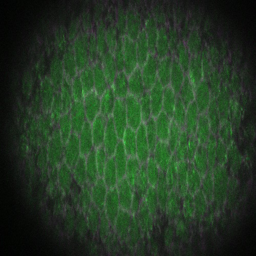

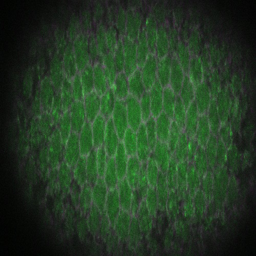

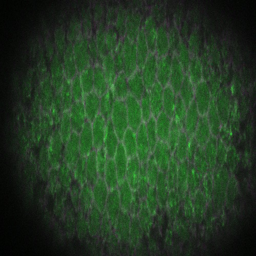

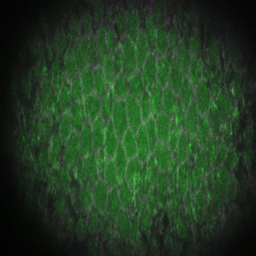

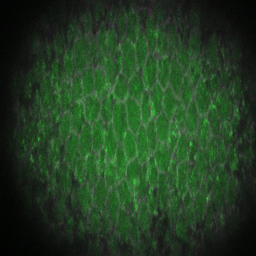

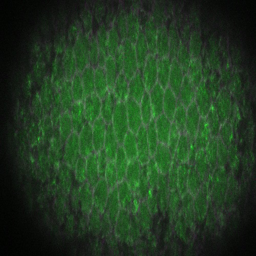

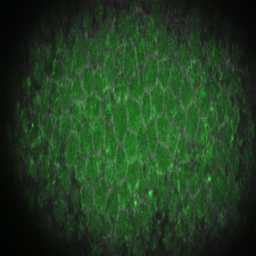

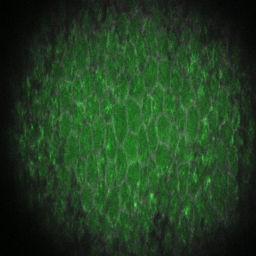

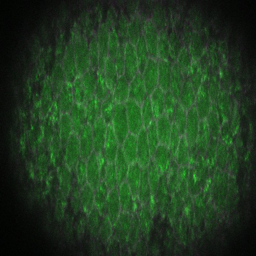

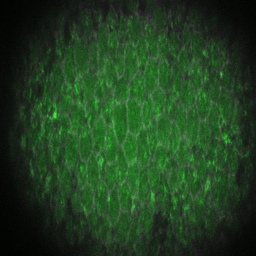

--------------------------------------
(10, 256, 256, 3)


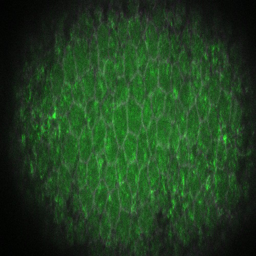

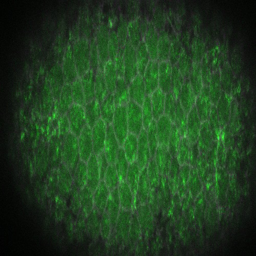

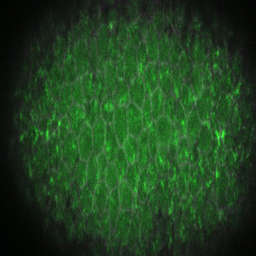

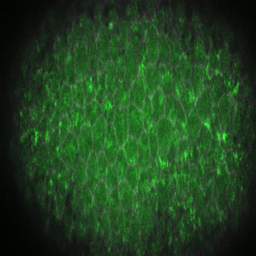

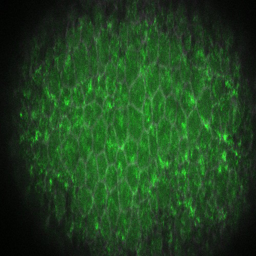

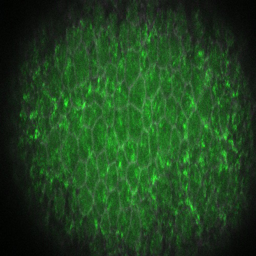

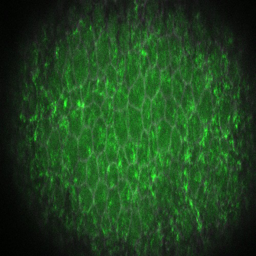

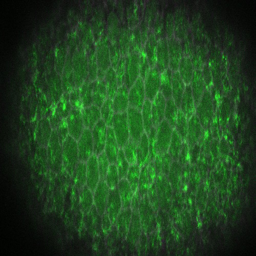

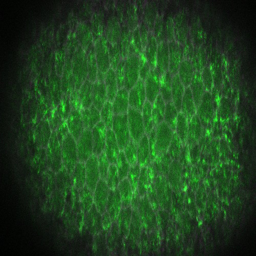

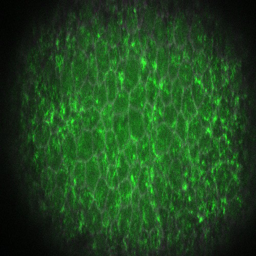

--------------------------------------
(10, 256, 256, 3)


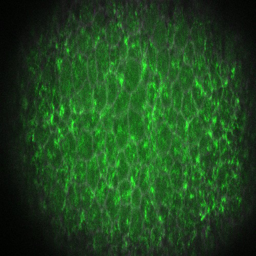

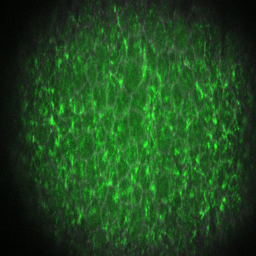

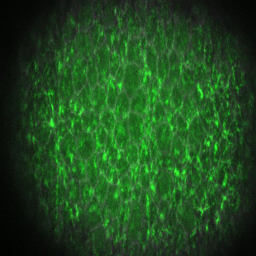

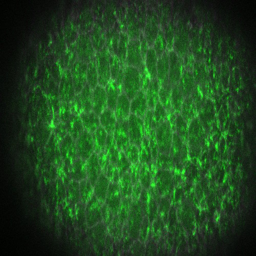

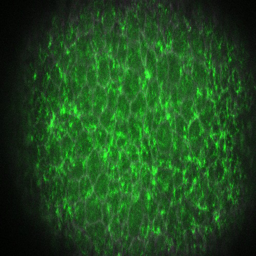

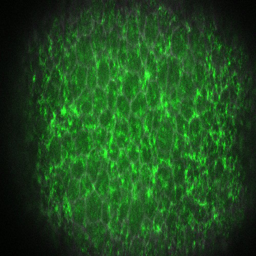

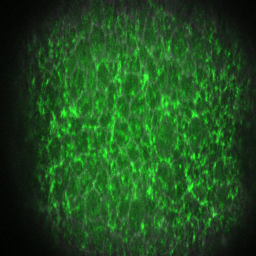

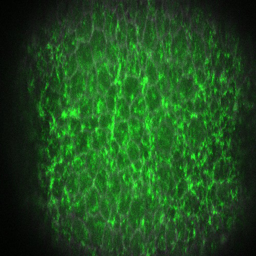

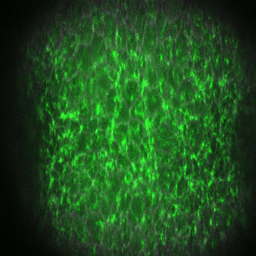

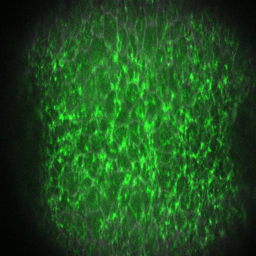

--------------------------------------
(10, 256, 256, 3)


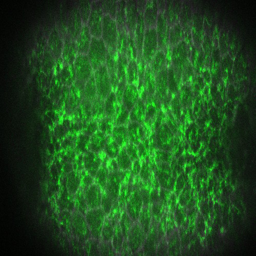

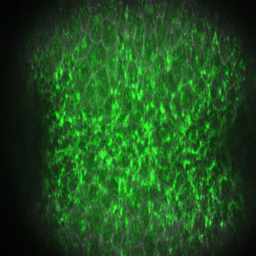

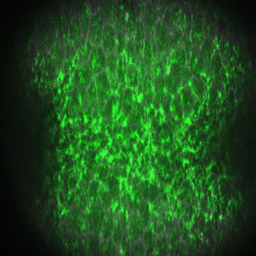

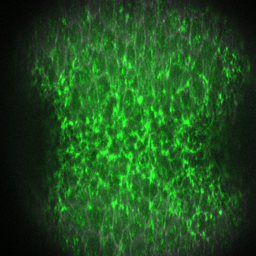

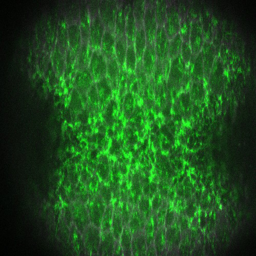

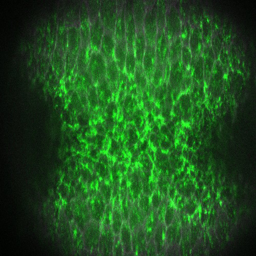

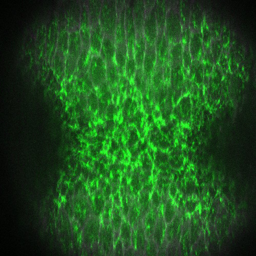

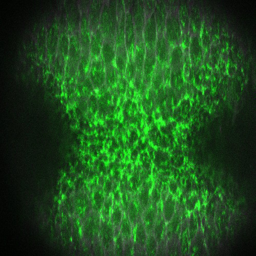

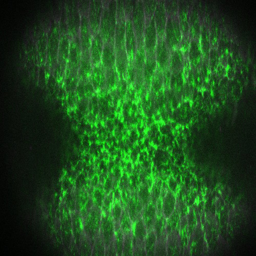

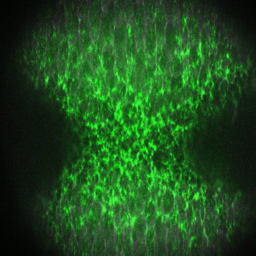

--------------------------------------
(10, 256, 256, 3)


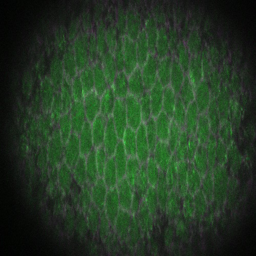

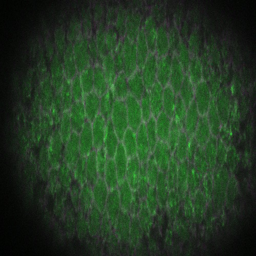

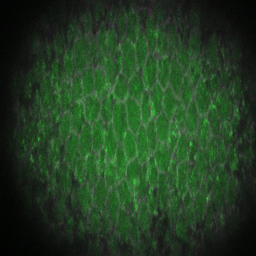

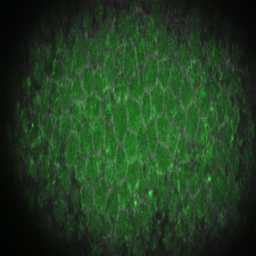

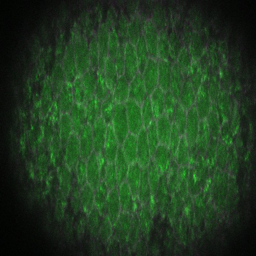

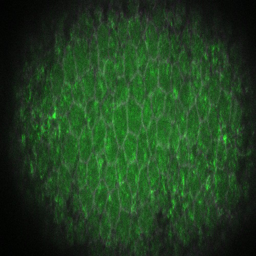

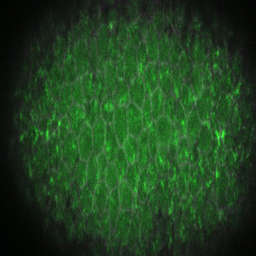

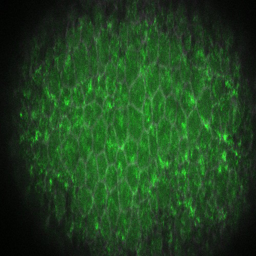

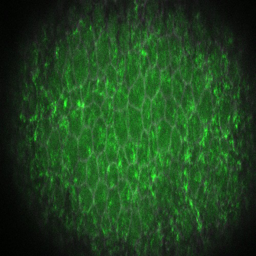

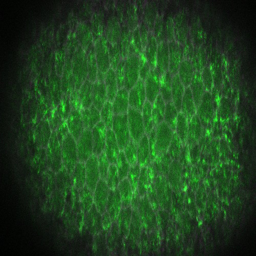

--------------------------------------
(10, 256, 256, 3)


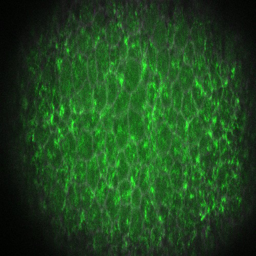

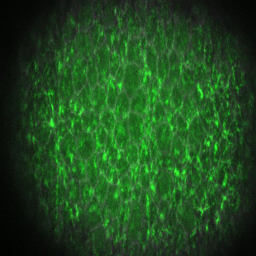

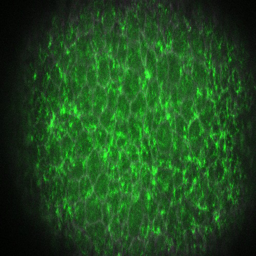

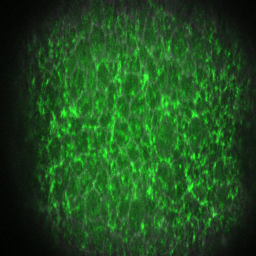

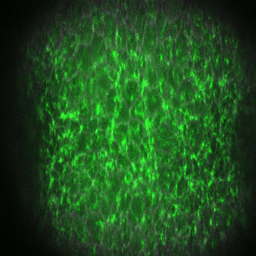

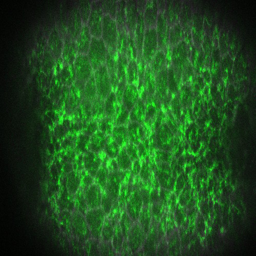

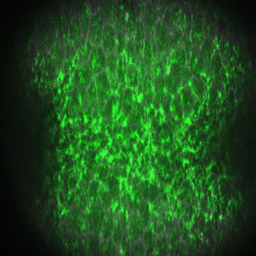

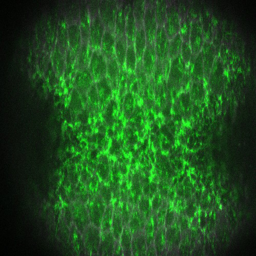

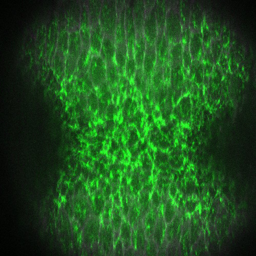

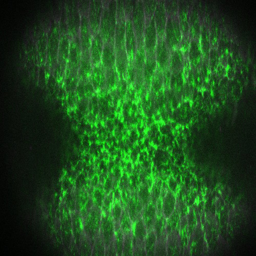

--------------------------------------
(10, 256, 256, 3)


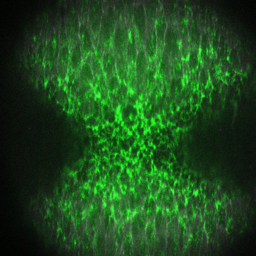

KeyboardInterrupt: ignored

In [ ]:
import time
count = 0
print(len(training_set))
for j in range(len(training_set)):
  print(training_set[j].shape)
  for i in range(len(training_set[j])):
    new_training_set = (training_set[j][i]*255).astype(np.uint8)
    img = Image.fromarray(new_training_set, 'RGB')
    display(img)
    count += 1
    if count == 10:
      count = 0
      print('--------------------------------------')
    time.sleep(1)

starting
got model
got test


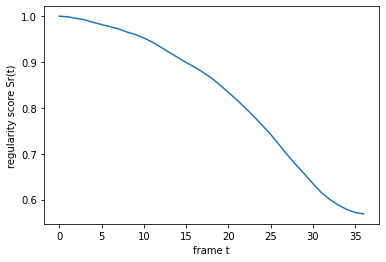

In [ ]:
evaluate([], False)